In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.model_selection import learning_curve

In [2]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=DM+Sans:ital,opsz,wght@0,9..40,100..1000;1,9..40,100..1000&display=swap');
div.text_cell {font-family : DM Sans, sans-serif !important;}
pre {font-family : DM Sans, sans-serif !important;}
</style>

# **Clasification Model Comparison Template** 

This Notebook compares the performance of different types of classification models on a dataset provided by the user. It is meant to assist in the model selection process, helping users discern the most suitible classification technique for their dataset. Users should store data in the data directory.

## Dataset Overview

We'll be working with a customer segmentation dataset from Kaggle. The function of this dataset is to classify customers into different segments based on their characteristics. The dataset contains customer information including demographic data and purchasing behavior. Our target variable is 'Segmentation', which categorizes customers into segments A, B, C, or D.

## Classification Techniques

We'll be implementing and comparing the following classification techniques using Scikit Learn:
1. Logistic Regression
2. K-Nearest Neighbors (KNN)
3. Decision Tree
4. Random Forest
5. Support Vector Machine (SVM)
6. Naive Bayes

Let's begin by loading and preparing our data.

### **Load In Data**

In [3]:
DATA_FILE_NAME: str = "customer_segmentation.csv"
COLUMNS_TO_DROP: list[str] = ["ID"]

In [4]:
def load_data(file_name: str = DATA_FILE_NAME, dropped_columns = COLUMNS_TO_DROP) -> pd.DataFrame:
    """
    Loads in user's input file as a pandas DataFrame.
    
     Args:
        file_name (str): Name of file containing data for training and testing the models
    Returns:
        pd.DataFrame: Dataframe of target and feature variable values for all data entries with both (returns single dataframe, target and feature variables not yet seperated)
    """
    file_name = "data/" + file_name
    file_extension = file_name.split(".")[-1]

    if file_extension == "csv":
        df = pd.read_csv(file_name)
    elif file_extension in ["xls", "xlsx"]:
        df = pd.read_excel(file_name)
    elif file_extension == "json":
        df = pd.read_json(file_name)
    else:
        raise ValueError("Unsupported file format. Please upload a CSV, Excel, or JSON file.")
    
    df.drop_duplicates(inplace = True)
    df.drop(columns = dropped_columns, inplace = True)
    
    return df


data_df = load_data()
print(len(data_df))
data_df.head()

8068


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### **Seperate Target and Feature Columns and Handle Missing Values**

In [5]:
TARGET_COLUMN_NAME: str = "Segmentation"
TARGET_VARIABLE_NAME: str = TARGET_COLUMN_NAME

##### Drop All Rows with Missing Values

In [6]:
def drop_rows_with_missing_values(df: pd.DataFrame = data_df) -> tuple:
    dropna_data_df = df.dropna()
    
    features_df = dropna_data_df.drop(axis = "columns", columns = [TARGET_COLUMN_NAME])
    targets_series = dropna_data_df[TARGET_COLUMN_NAME]
    
    return (features_df, targets_series)


dropna_X, dropna_y = drop_rows_with_missing_values()

print(len(dropna_X))
print(len(dropna_y))
dropna_X.head()

6665
6665


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
5,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6
6,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6


##### Impute Missing Values

In [7]:
# Use to understand the type of missing values for the missing_values parameter of SimpleImputer
rows_with_any_missing_values = data_df[data_df.isnull().any(axis = "columns")]
rows_with_any_missing_values.head(10)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
12,Female,No,19,No,Executive,0.0,Low,NaN,Cat_3,D
13,Male,Yes,70,No,Lawyer,NaN,Low,1.0,Cat_6,A
24,Female,NaN,58,No,Executive,1.0,Average,3.0,Cat_3,B
33,Male,No,26,No,Homemaker,9.0,Low,NaN,Cat_6,D
39,Male,Yes,56,Yes,Artist,NaN,Average,2.0,Cat_6,C
43,Female,Yes,49,Yes,Artist,1.0,Low,2.0,NaN,C
45,Female,Yes,79,No,Lawyer,NaN,High,2.0,Cat_6,A
47,Female,No,29,Yes,Healthcare,NaN,Low,1.0,Cat_7,A


In [8]:
numerical_columns = list(data_df.select_dtypes(include = np.number).columns)
print(f"Numerical Features: {numerical_columns}")

categorical_columns = list(data_df.select_dtypes(exclude = np.number).columns)
print(f"Categorical Features: {categorical_columns}")


def impute_missing_values(df: pd.DataFrame = data_df.copy(), numerical_columns_to_impute = numerical_columns, categorical_columns_to_impute = categorical_columns) -> tuple:
    numerical_imputer = SimpleImputer(strategy = "median")
    categorical_imputer = SimpleImputer(strategy = "most_frequent")
    
    df[numerical_columns_to_impute] = numerical_imputer.fit_transform(df[numerical_columns_to_impute])
    df[categorical_columns_to_impute] = categorical_imputer.fit_transform(df[categorical_columns_to_impute])
    
    features_df = df.drop(axis = "columns", columns = [TARGET_COLUMN_NAME])
    targets_series = df[TARGET_COLUMN_NAME]
    
    return (features_df, targets_series)


imputed_X, imputed_y = impute_missing_values()

print(len(imputed_X))
imputed_X.dropna(inplace = True)
print(len(imputed_X))

imputed_X.head(10)

Numerical Features: ['Age', 'Work_Experience', 'Family_Size']
Categorical Features: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']
8068
8068


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22.0,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38.0,Yes,Engineer,1.0,Average,3.0,Cat_4
2,Female,Yes,67.0,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67.0,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40.0,Yes,Entertainment,1.0,High,6.0,Cat_6
5,Male,Yes,56.0,No,Artist,0.0,Average,2.0,Cat_6
6,Male,No,32.0,Yes,Healthcare,1.0,Low,3.0,Cat_6
7,Female,No,33.0,Yes,Healthcare,1.0,Low,3.0,Cat_6
8,Female,Yes,61.0,Yes,Engineer,0.0,Low,3.0,Cat_7
9,Female,Yes,55.0,Yes,Artist,1.0,Average,4.0,Cat_6


### **Preprocess Data**

In [9]:
numerical_columns = list(data_df.select_dtypes(include = np.number).columns)
print(f"Numerical Features: {numerical_columns}")

categorical_columns = list(data_df.select_dtypes(exclude = np.number).columns)
print(f"Categorical Features: {categorical_columns}")
print()

for column in categorical_columns:
    print(f"{column} Column Unique Entries: {data_df.dropna()[column].unique()}")
    print()

data_df.head()

Numerical Features: ['Age', 'Work_Experience', 'Family_Size']
Categorical Features: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']

Gender Column Unique Entries: ['Male' 'Female']

Ever_Married Column Unique Entries: ['No' 'Yes']

Graduated Column Unique Entries: ['No' 'Yes']

Profession Column Unique Entries: ['Healthcare' 'Engineer' 'Lawyer' 'Artist' 'Doctor' 'Homemaker'
 'Entertainment' 'Marketing' 'Executive']

Spending_Score Column Unique Entries: ['Low' 'High' 'Average']

Var_1 Column Unique Entries: ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' 'Cat_5']

Segmentation Column Unique Entries: ['D' 'B' 'C' 'A']



,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [10]:
nominal_categorical_column_names: list[str] = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']
ordinal_categorical_column_names: list[str] = ["Spending_Score"]
ordianl_categories_ordered_list: list[list[str]] = [['Low', 'Average', 'High']]
numerical_colums_to_scale: list[str] = numerical_columns
onehot_drop_column = "first"

X_train, X_test, y_train, y_test = train_test_split(dropna_X, dropna_y, test_size = 0.2, random_state = 42)

general_feature_preprocessor = ColumnTransformer(
    transformers = [
        ('nominal_encoder', OneHotEncoder(drop = onehot_drop_column), nominal_categorical_column_names),
        ("ordinal_encoder", OrdinalEncoder(categories = ordianl_categories_ordered_list), ordinal_categorical_column_names),
        ('scaler', StandardScaler(), numerical_colums_to_scale)
    ]
)
nominal_target_preprocessor = LabelEncoder()

y_train = nominal_target_preprocessor.fit_transform(y_train)
y_test = nominal_target_preprocessor.fit_transform(y_test)

In [11]:
models = {
    'Logistic Regression': {
        'model': make_pipeline(general_feature_preprocessor, LogisticRegression(max_iter = 1000)),
        'param_grid': {
            'logisticregression__C': [0.1, 1, 10],
            'logisticregression__solver': ['liblinear', 'saga']
        }
    },
    'KNN': {
        'model': make_pipeline(general_feature_preprocessor, KNeighborsClassifier()),
        'param_grid': {
            'kneighborsclassifier__n_neighbors': [3, 5, 7],
            'kneighborsclassifier__weights': ['uniform', 'distance']
        }
    },
    'Decision Tree': {
        'model': make_pipeline(general_feature_preprocessor, DecisionTreeClassifier(random_state = 42)),
        'param_grid': {
            'decisiontreeclassifier__max_depth': [None, 5, 10],
            'decisiontreeclassifier__min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': make_pipeline(general_feature_preprocessor, RandomForestClassifier(random_state = 42)),
        'param_grid': {
            'randomforestclassifier__n_estimators': [100, 200],
            'randomforestclassifier__max_depth': [None, 5, 10]
        }
    },
    'SVC': {
        'model': make_pipeline(general_feature_preprocessor, SVC(probability = True, random_state = 42)),
        'param_grid': {
            'svc__C': [0.1, 1, 10],
            'svc__kernel': ['linear', 'rbf']
        }
    },
    'Naive Bayes': {
        'model': make_pipeline(general_feature_preprocessor, GaussianNB()),
        'param_grid': {}
    }
}

results = {}
result_df_data = []

for model_name, model_data in models.items():
    print(f"Training and Evaluating: {model_name}") 
    
    model = model_data['model']
    param_grid = model_data['param_grid']
    
    stratifiedkf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    grid_search = GridSearchCV(model, param_grid, cv = stratifiedkf, scoring = 'accuracy')
    
    tune_train_start_time = time.time()
    grid_search.fit(X_train, y_train)
    tune_train_end_time = time.time()
    tune_train_time = tune_train_end_time - tune_train_start_time
    print(f"    {model_name} Hyperparameter Tuning and Model Training Time: {tune_train_time:.2f} seconds")
    
    best_model = grid_search.best_estimator_
    
    results[model_name] = {
        'best_model': best_model,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        "cv_results": grid_search.cv_results_,
        "tune_train_time": tune_train_time
    }
    
    y_train_predictions = best_model.predict(X_train)
    y_test_predictions = best_model.predict(X_test)
    y_test_prediction_probabilities = best_model.predict_proba(X_test)
    
    results[model_name]["y_train_predictions"] = y_train_predictions
    results[model_name]["y_test_predictions"] = y_test_predictions
    results[model_name]["y_test_prediction_probabilities"] = y_test_prediction_probabilities
    
    accuracy = accuracy_score(y_test, y_test_predictions)
    precision = precision_score(y_test, y_test_predictions, average = 'weighted')
    recall = recall_score(y_test, y_test_predictions, average = 'weighted')
    f1 = f1_score(y_test, y_test_predictions, average = 'weighted')
    
    results[model_name]["accuracy"] = accuracy
    results[model_name]["precision"] = precision
    results[model_name]["recall"] = recall
    results[model_name]["f1"] = f1
    

Training and Evaluating: Logistic Regression
    Logistic Regression Hyperparameter Tuning and Model Training Time: 1.39 seconds
Training and Evaluating: KNN
    KNN Hyperparameter Tuning and Model Training Time: 0.81 seconds
Training and Evaluating: Decision Tree
    Decision Tree Hyperparameter Tuning and Model Training Time: 0.88 seconds
Training and Evaluating: Random Forest
    Random Forest Hyperparameter Tuning and Model Training Time: 10.34 seconds
Training and Evaluating: SVC
    SVC Hyperparameter Tuning and Model Training Time: 74.64 seconds
Training and Evaluating: Naive Bayes
    Naive Bayes Hyperparameter Tuning and Model Training Time: 0.10 seconds


In [12]:
def summarize_results(results):
    summary = pd.DataFrame({
        'Model': results.keys(),
        'Accuracy': [result['accuracy'] for result in results.values()],
        'Precision': [result['precision'] for result in results.values()],
        'Recall': [result['recall'] for result in results.values()],
        'F1 Score': [result['f1'] for result in results.values()]
    })
    display(md("## Model Performance Summary"))
    display(summary)
    
    best_model = summary.loc[summary['F1 Score'].idxmax(), 'Model']
    display(md(f"#### **Best Model:** {best_model} (based on F1 Score)"))
    return best_model

best_model = summarize_results(results)

## Model Performance Summary

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.515379,0.505284,0.515379,0.500068
1,KNN,0.478620,0.485988,0.478620,0.480466
2,Decision Tree,0.494374,0.493585,0.494374,0.479250
3,Random Forest,0.522881,0.517522,0.522881,0.518184
4,SVC,0.513878,0.515221,0.513878,0.512741
5,Naive Bayes,0.454614,0.448382,0.454614,0.424951


#### **Best Model:** Random Forest (based on F1 Score)

In [13]:
FEATURE_LIST = list(X_train.columns)
NUM_FEATURES = len(FEATURE_LIST)


NUM_DECIMAL_PLACES: int = 5
TABLE_FONT_SIZE: int = 16 #px

In [14]:
def create_fit_function_equation_markdown(intercept: int, coefficient_list: list, feature_list: list = FEATURE_LIST, num_decimal_places: int = NUM_DECIMAL_PLACES) -> str:
    model_equation = f"{TARGET_VARIABLE_NAME} = {intercept:.{num_decimal_places}f}"
    for i in range(len(coefficient_list)):
        model_equation += f" + {coefficient_list[i]:.{num_decimal_places}f}({feature_list[i]})"
    return model_equation


In [15]:
target_classes = nominal_target_preprocessor.classes_

def plot_confusion_matrix(model_name, y_true, y_predictions, classes = target_classes):
    cm = confusion_matrix(y_true, y_predictions)
    plt.figure(figsize = (12, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
    disp.plot(cmap = "Blues")
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    
def plot_roc_curve(model_name, y_true, y_prediction_probabilities, classes = target_classes):
    n_classes = len(classes)
    y_bin = label_binarize(y_true, classes = range(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prediction_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    plt.figure(figsize = (10, 8))
    for i, color in zip(range(n_classes), ['blue', 'red', 'green', 'orange']):
        plt.plot(fpr[i], tpr[i], color = color, lw = 2,
                 label = f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw = 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc = "lower right")
    plt.show()
    
    
def plot_multiclass_precision_recall_curve(model_name, y_true, y_prediction_probabilities, classes = target_classes):
    n_classes = len(classes)
    y_bin = label_binarize(y_true, classes = range(n_classes))
    
    precision = dict()
    recall = dict()
    avg_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_prediction_probabilities[:, i])
        avg_precision[i] = average_precision_score(y_bin[:, i], y_prediction_probabilities[:, i])
    
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), ['blue', 'red', 'green', 'orange']):
        plt.plot(recall[i], precision[i], color = color, lw = 2,
                 label = f'Precision-Recall curve of class {classes[i]} (AUC = {avg_precision[i]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend(loc = "lower left")
    plt.show()
    

feature_columns = list(X_train.columns)
def get_featuere_names(X_column_names = feature_columns):
    feature_names = [column_name.replace("_", " ") for column_name in X_column_names]
    return feature_names

feature_names = get_featuere_names()
print(feature_columns)
print(feature_names)

def plot_feature_importance(model_name, model, feature_names = feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"{model_name} Feature Importances")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation = 90)
    plt.tight_layout()
    plt.show()
    

def plot_learning_curve(estimator, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes = np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve: {model_name}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.fill_between(train_sizes, (train_scores_mean - train_scores_std),
                     (train_scores_mean + train_scores_std), alpha = 0.1, color = "r")
    plt.fill_between(train_sizes, (test_scores_mean - test_scores_std),
                     (test_scores_mean + test_scores_std), alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r", label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g", label = "Cross-validation score")
    plt.legend(loc = "best")
    plt.show()

['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
['Gender', 'Ever Married', 'Age', 'Graduated', 'Profession', 'Work Experience', 'Spending Score', 'Family Size', 'Var 1']


In [16]:
logistic_model_name = "Logistic Regression"

logistic_best_model = results[logistic_model_name]["best_model"]

logistic_y_test_predictions = results[logistic_model_name]["y_test_predictions"]
logistic_y_test_prediction_probabilities = results[logistic_model_name]["y_test_prediction_probabilities"]

logistic_accuracy = results[logistic_model_name]["accuracy"]
logistic_precision = results[logistic_model_name]["precision"]
logistic_recall = results[logistic_model_name]["recall"]
logistic_f1_score = results[logistic_model_name]["f1"]

In [17]:
logistic_accuracy_string = f"{logistic_model_name} Accuracy: {logistic_accuracy}"
logistic_precision_string = f"{logistic_model_name} Precision: {logistic_precision}"
logistic_recall_string = f"{logistic_model_name} Recall: {logistic_recall}"
logistic_f1_score_string = f"{logistic_model_name} F1 Score: {logistic_f1_score}"

logistic_best_hyperparameters = results["Logistic Regression"]["best_params"]
print(f"{logistic_model_name} Model Best Hyperparameter Combination: {logistic_best_hyperparameters}")
print()
print(logistic_accuracy_string)
print(logistic_precision_string)
print(logistic_recall_string)
print(logistic_f1_score_string)

Logistic Regression Model Best Hyperparameter Combination: {'logisticregression__C': 1, 'logisticregression__solver': 'saga'}

Logistic Regression Accuracy: 0.5153788447111778
Logistic Regression Precision: 0.505283729718225
Logistic Regression Recall: 0.5153788447111778
Logistic Regression F1 Score: 0.5000682041748912


<Figure size 1200x800 with 0 Axes>

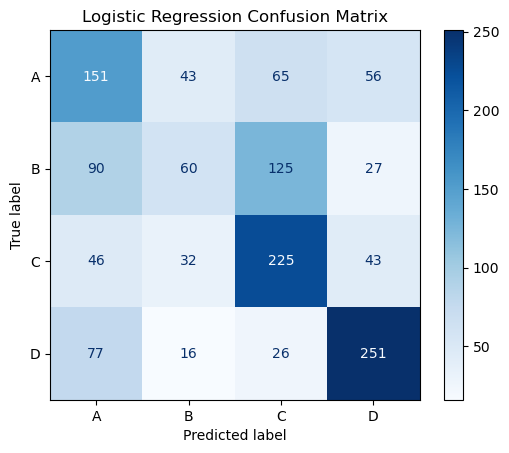

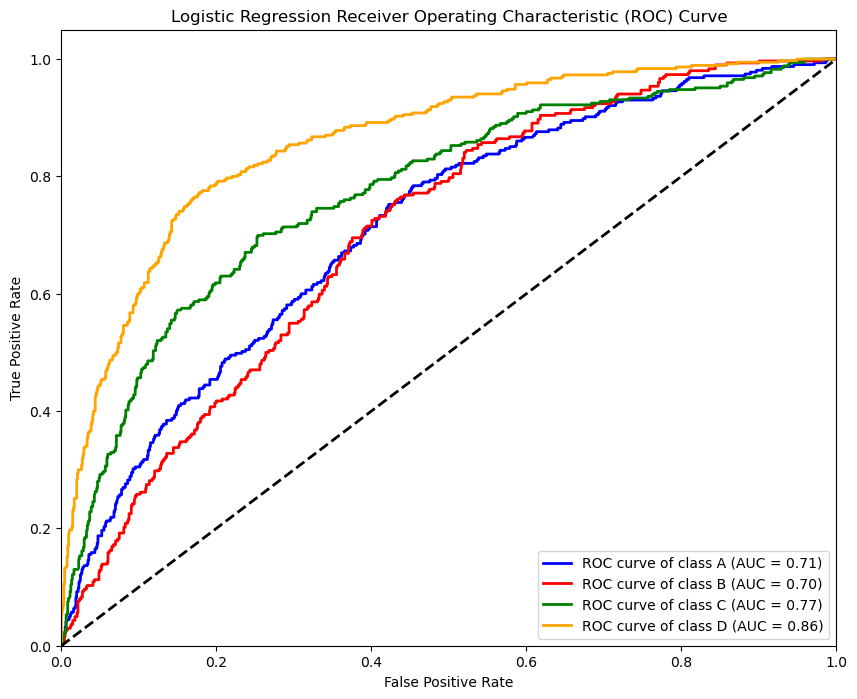

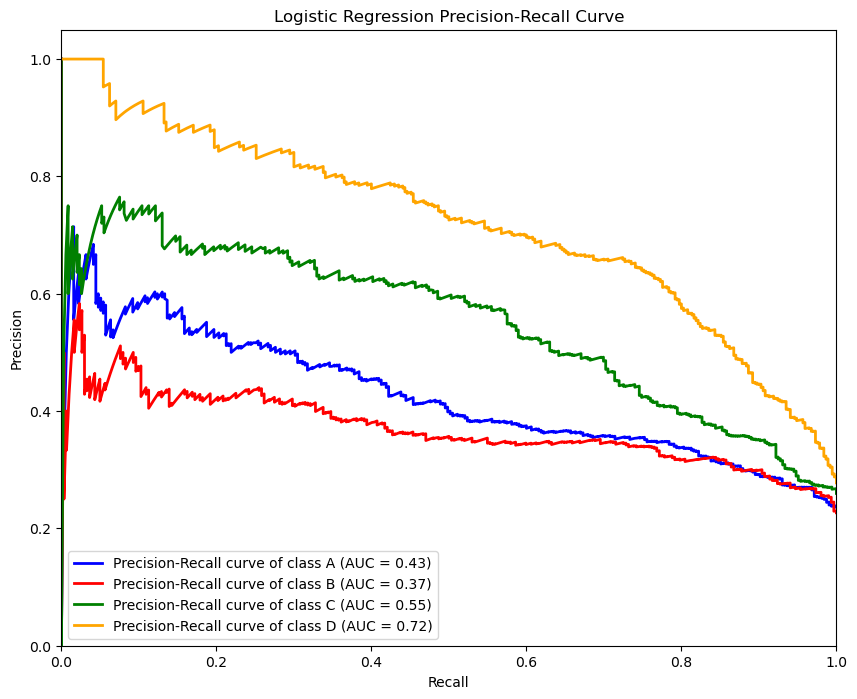

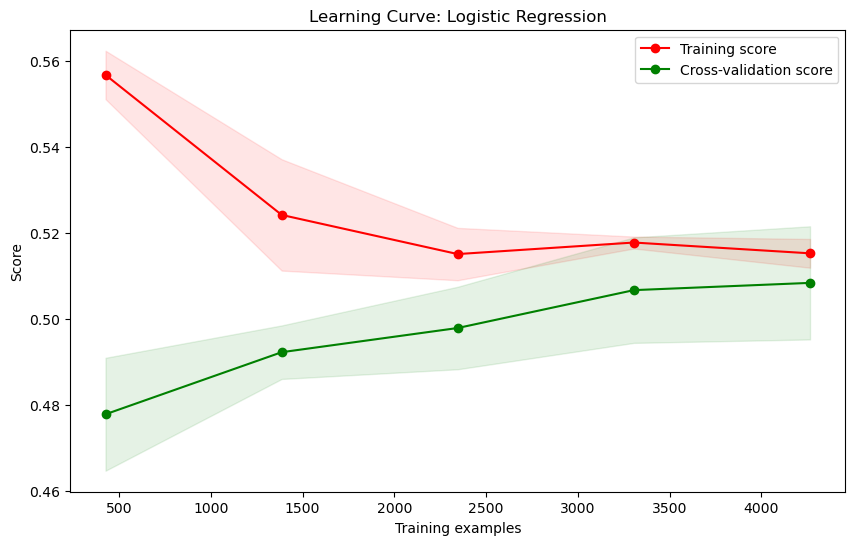

In [18]:
plot_confusion_matrix(logistic_model_name, y_test, logistic_y_test_predictions)
plot_roc_curve(logistic_model_name, y_test, logistic_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(logistic_model_name, y_test, logistic_y_test_prediction_probabilities)
plot_learning_curve(logistic_best_model, X_train, y_train, logistic_model_name)

In [19]:
knn_model_name = "KNN"

knn_best_model = results[knn_model_name]["best_model"]

knn_y_test_predictions = results[knn_model_name]["y_test_predictions"]
knn_y_test_prediction_probabilities = results[knn_model_name]["y_test_prediction_probabilities"]

knn_accuracy = results[knn_model_name]["accuracy"]
knn_precision = results[knn_model_name]["precision"]
knn_recall = results[knn_model_name]["recall"]
knn_f1_score = results[knn_model_name]["f1"]

In [20]:
knn_accuracy_string = f"{knn_model_name} Accuracy: {knn_accuracy}"
knn_precision_string = f"{knn_model_name} Precision: {knn_precision}"
knn_recall_string = f"{knn_model_name} Recall: {knn_recall}"
knn_f1_score_string = f"{knn_model_name} F1 Score: {knn_f1_score}"

knn_best_hyperparameters = results["KNN"]["best_params"]
print(f"{knn_model_name} Model Best Hyperparameter Combination: {knn_best_hyperparameters}")
print()
print(knn_accuracy_string)
print(knn_precision_string)
print(knn_recall_string)
print(knn_f1_score_string)

KNN Model Best Hyperparameter Combination: {'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__weights': 'uniform'}

KNN Accuracy: 0.47861965491372843
KNN Precision: 0.485988417619404
KNN Recall: 0.47861965491372843
KNN F1 Score: 0.4804656381398804


<Figure size 1200x800 with 0 Axes>

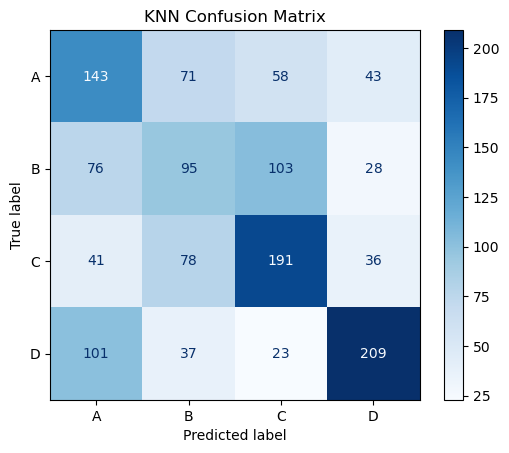

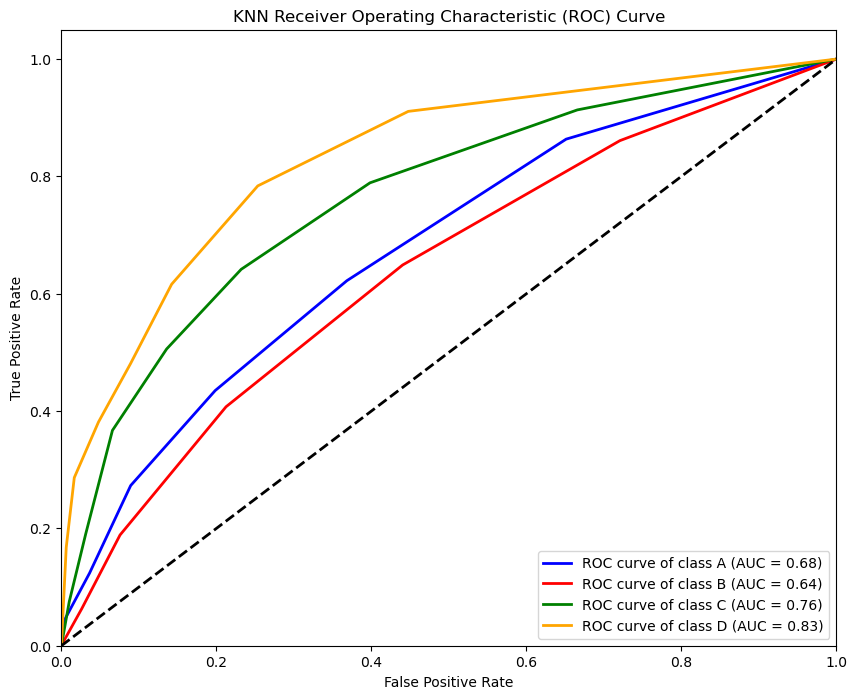

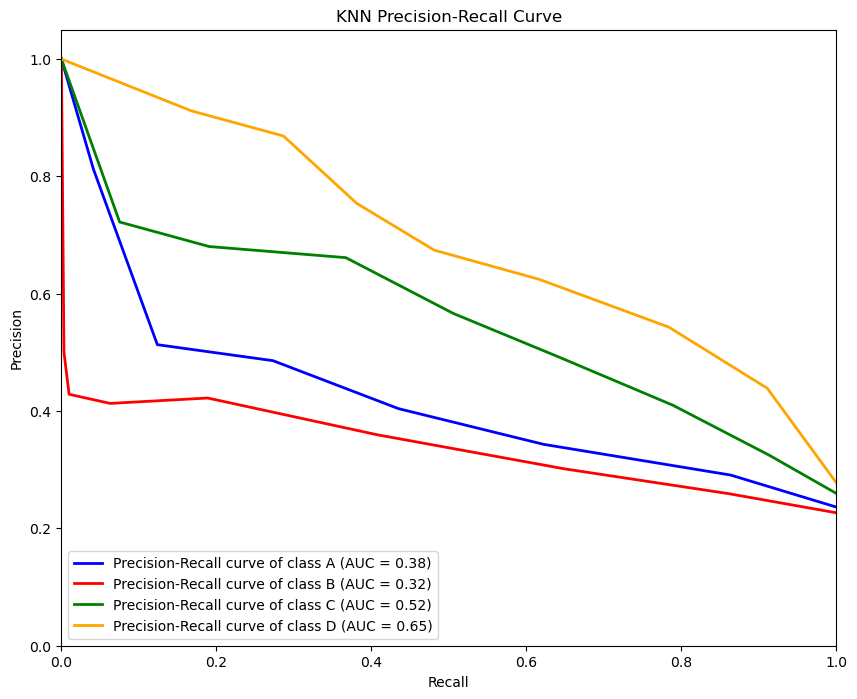

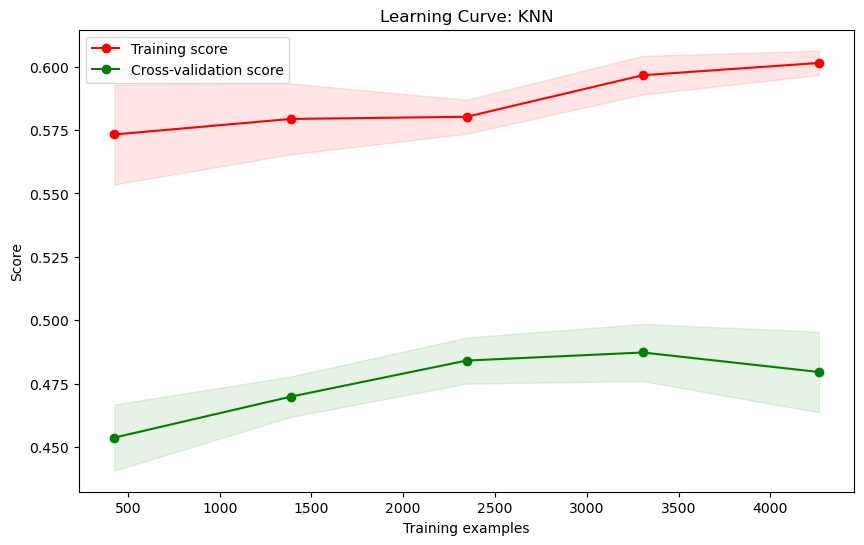

In [21]:
plot_confusion_matrix(knn_model_name, y_test, knn_y_test_predictions)
plot_roc_curve(knn_model_name, y_test, knn_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(knn_model_name, y_test, knn_y_test_prediction_probabilities)
plot_learning_curve(knn_best_model, X_train, y_train, knn_model_name)

In [22]:
decision_tree_model_name = "Decision Tree"

decision_tree_best_model = results[decision_tree_model_name]["best_model"]

decision_tree_y_test_predictions = results[decision_tree_model_name]["y_test_predictions"]
decision_tree_y_test_prediction_probabilities = results[decision_tree_model_name]["y_test_prediction_probabilities"]

decision_tree_accuracy = results[decision_tree_model_name]["accuracy"]
decision_tree_precision = results[decision_tree_model_name]["precision"]
decision_tree_recall = results[decision_tree_model_name]["recall"]
decision_tree_f1_score = results[decision_tree_model_name]["f1"]

In [23]:
decision_tree_accuracy_string = f"{decision_tree_model_name} Accuracy: {decision_tree_accuracy}"
decision_tree_precision_string = f"{decision_tree_model_name} Precision: {decision_tree_precision}"
decision_tree_recall_string = f"{decision_tree_model_name} Recall: {decision_tree_recall}"
decision_tree_f1_score_string = f"{decision_tree_model_name} F1 Score: {decision_tree_f1_score}"

decision_tree_best_hyperparameters = results["Decision Tree"]["best_params"]
print(f"{decision_tree_model_name} Model Best Hyperparameter Combination: {decision_tree_best_hyperparameters}")
print()
print(decision_tree_accuracy_string)
print(decision_tree_precision_string)
print(decision_tree_recall_string)
print(decision_tree_f1_score_string)

Decision Tree Model Best Hyperparameter Combination: {'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_split': 2}

Decision Tree Accuracy: 0.4943735933983496
Decision Tree Precision: 0.4935853954178486
Decision Tree Recall: 0.4943735933983496
Decision Tree F1 Score: 0.47925032448175486


<Figure size 1200x800 with 0 Axes>

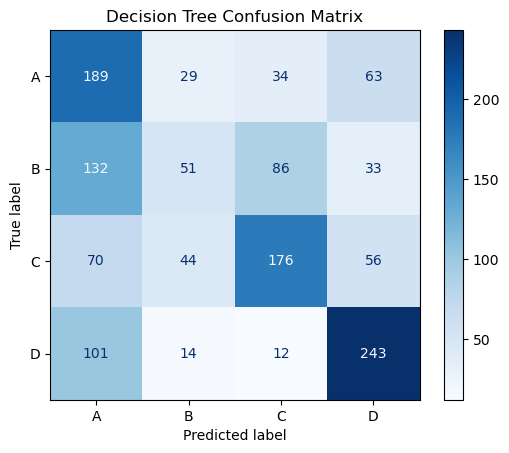

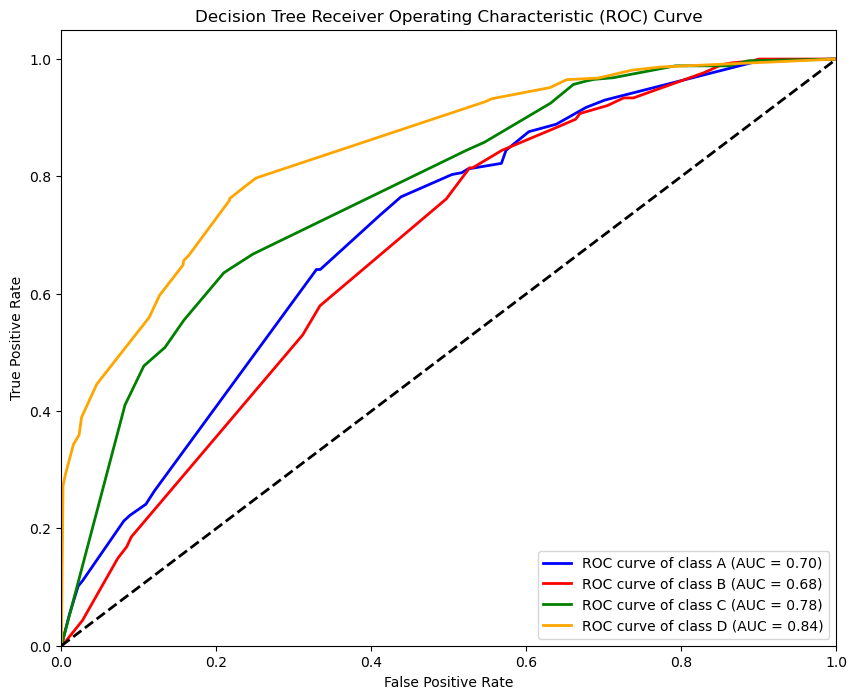

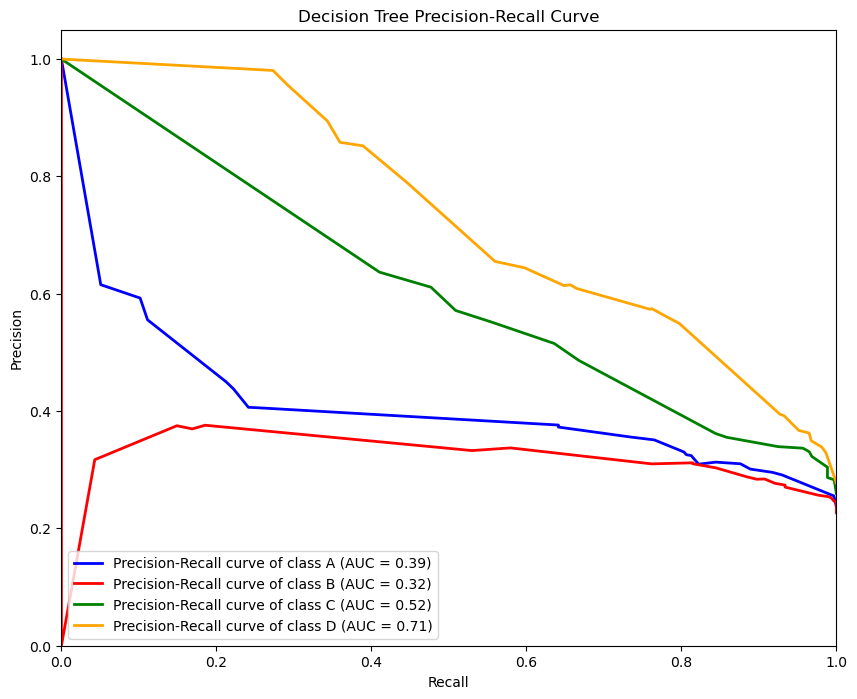

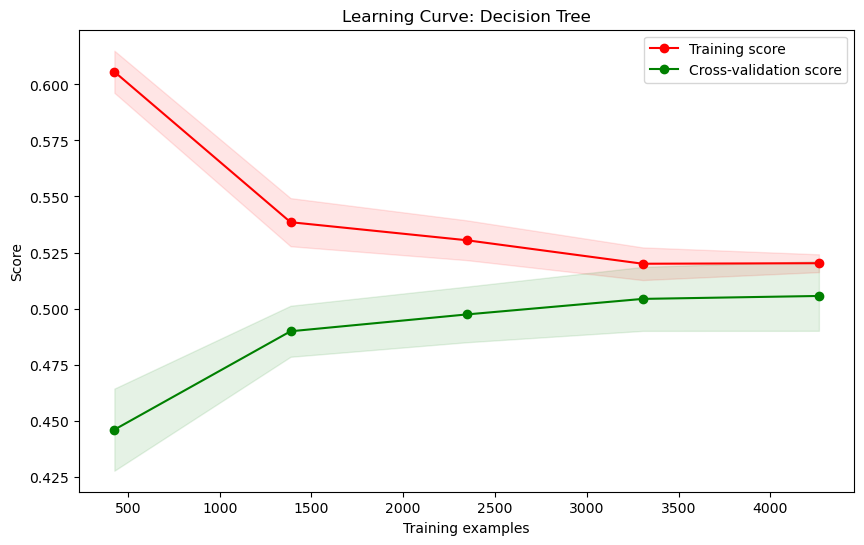

In [24]:
plot_confusion_matrix(decision_tree_model_name, y_test, decision_tree_y_test_predictions)
plot_roc_curve(decision_tree_model_name, y_test, decision_tree_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(decision_tree_model_name, y_test, decision_tree_y_test_prediction_probabilities)
plot_learning_curve(decision_tree_best_model, X_train, y_train, decision_tree_model_name)

In [25]:
random_forest_model_name = "Random Forest"

random_forest_best_model = results[random_forest_model_name]["best_model"]

random_forest_y_test_predictions = results[random_forest_model_name]["y_test_predictions"]
random_forest_y_test_prediction_probabilities = results[random_forest_model_name]["y_test_prediction_probabilities"]

random_forest_accuracy = results[random_forest_model_name]["accuracy"]
random_forest_precision = results[random_forest_model_name]["precision"]
random_forest_recall = results[random_forest_model_name]["recall"]
random_forest_f1_score = results[random_forest_model_name]["f1"]

In [26]:
random_forest_accuracy_string = f"{random_forest_model_name} Accuracy: {random_forest_accuracy}"
random_forest_precision_string = f"{random_forest_model_name} Precision: {random_forest_precision}"
random_forest_recall_string = f"{random_forest_model_name} Recall: {random_forest_recall}"
random_forest_f1_score_string = f"{random_forest_model_name} F1 Score: {random_forest_f1_score}"

random_forest_best_hyperparameters = results["Random Forest"]["best_params"]
print(f"{random_forest_model_name} Model Best Hyperparameter Combination: {random_forest_best_hyperparameters}")
print()
print(random_forest_accuracy_string)
print(random_forest_precision_string)
print(random_forest_recall_string)
print(random_forest_f1_score_string)

Random Forest Model Best Hyperparameter Combination: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 100}

Random Forest Accuracy: 0.522880720180045
Random Forest Precision: 0.5175218220817924
Random Forest Recall: 0.522880720180045
Random Forest F1 Score: 0.5181841241043608


<Figure size 1200x800 with 0 Axes>

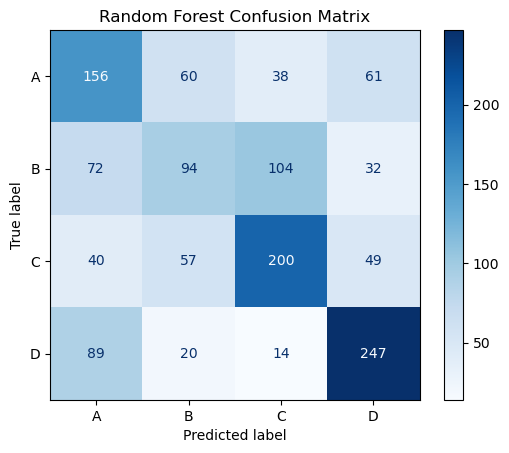

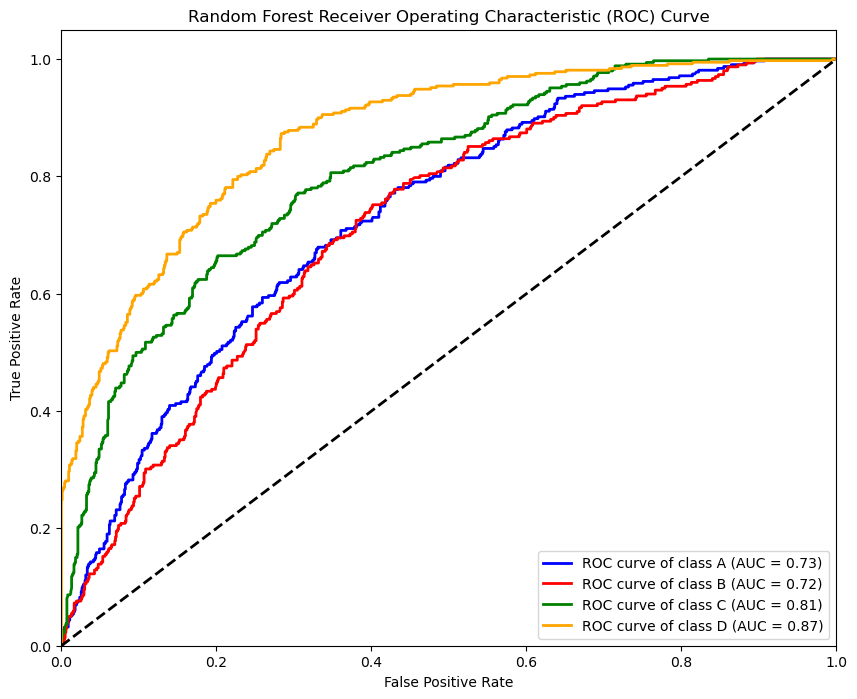

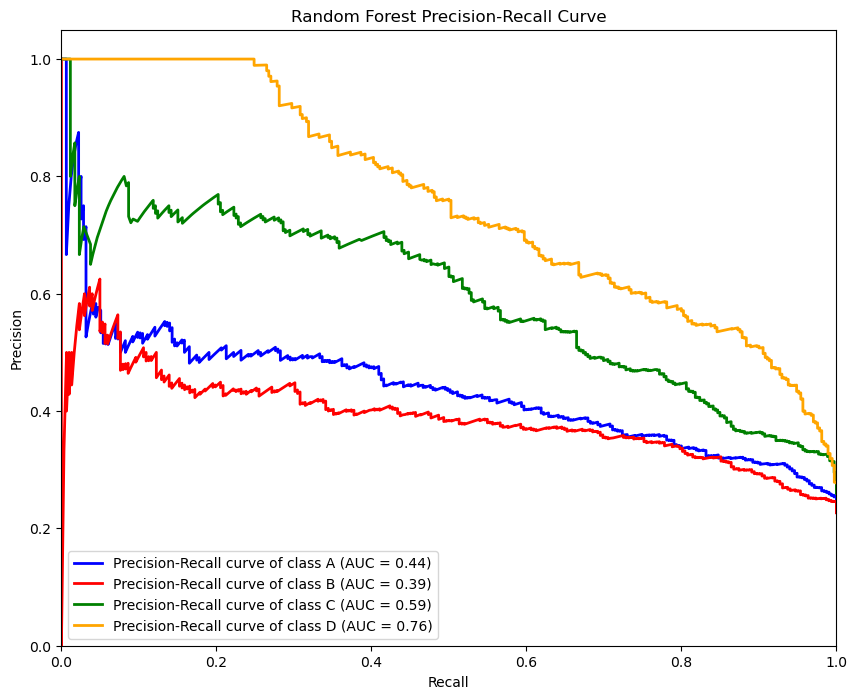

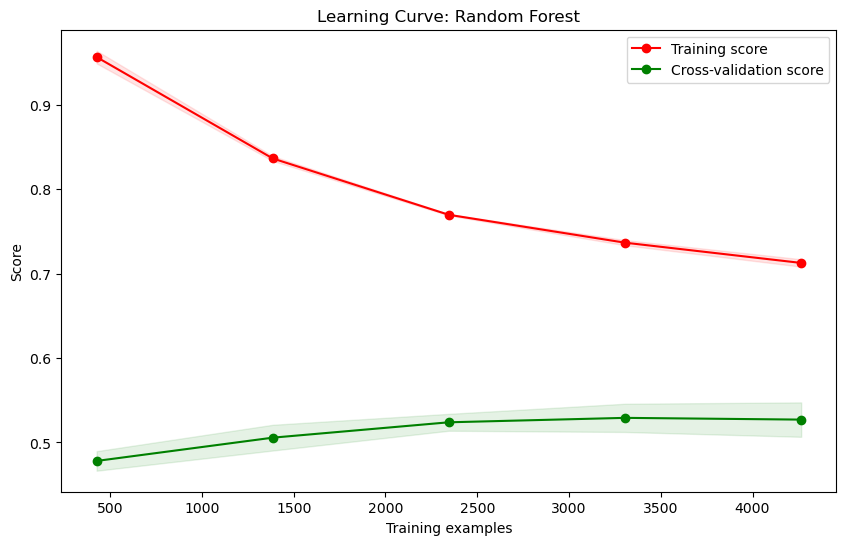

In [27]:
plot_confusion_matrix(random_forest_model_name, y_test, random_forest_y_test_predictions)
plot_roc_curve(random_forest_model_name, y_test, random_forest_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(random_forest_model_name, y_test, random_forest_y_test_prediction_probabilities)
plot_learning_curve(random_forest_best_model, X_train, y_train, random_forest_model_name)

In [28]:
svc_model_name = "SVC"

svc_best_model = results[svc_model_name]["best_model"]

svc_y_test_predictions = results[svc_model_name]["y_test_predictions"]
svc_y_test_prediction_probabilities = results[svc_model_name]["y_test_prediction_probabilities"]

svc_accuracy = results[svc_model_name]["accuracy"]
svc_precision = results[svc_model_name]["precision"]
svc_recall = results[svc_model_name]["recall"]
svc_f1_score = results[svc_model_name]["f1"]

In [29]:
svc_accuracy_string = f"{svc_model_name} Accuracy: {svc_accuracy}"
svc_precision_string = f"{svc_model_name} Precision: {svc_precision}"
svc_recall_string = f"{svc_model_name} Recall: {svc_recall}"
svc_f1_score_string = f"{svc_model_name} F1 Score: {svc_f1_score}"

svc_best_hyperparameters = results["SVC"]["best_params"]
print(f"{svc_model_name} Model Best Hyperparameter Combination: {svc_best_hyperparameters}")
print()
print(svc_accuracy_string)
print(svc_precision_string)
print(svc_recall_string)
print(svc_f1_score_string)

SVC Model Best Hyperparameter Combination: {'svc__C': 1, 'svc__kernel': 'rbf'}

SVC Accuracy: 0.5138784696174044
SVC Precision: 0.5152206306714875
SVC Recall: 0.5138784696174044
SVC F1 Score: 0.5127405956478682


<Figure size 1200x800 with 0 Axes>

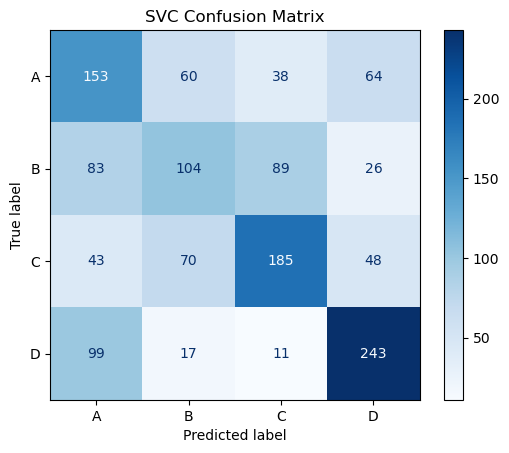

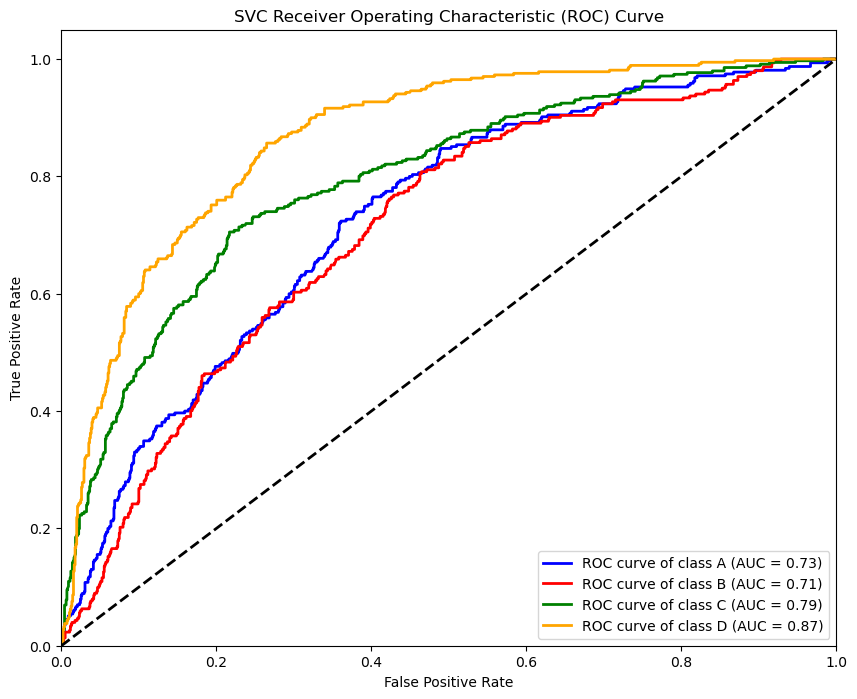

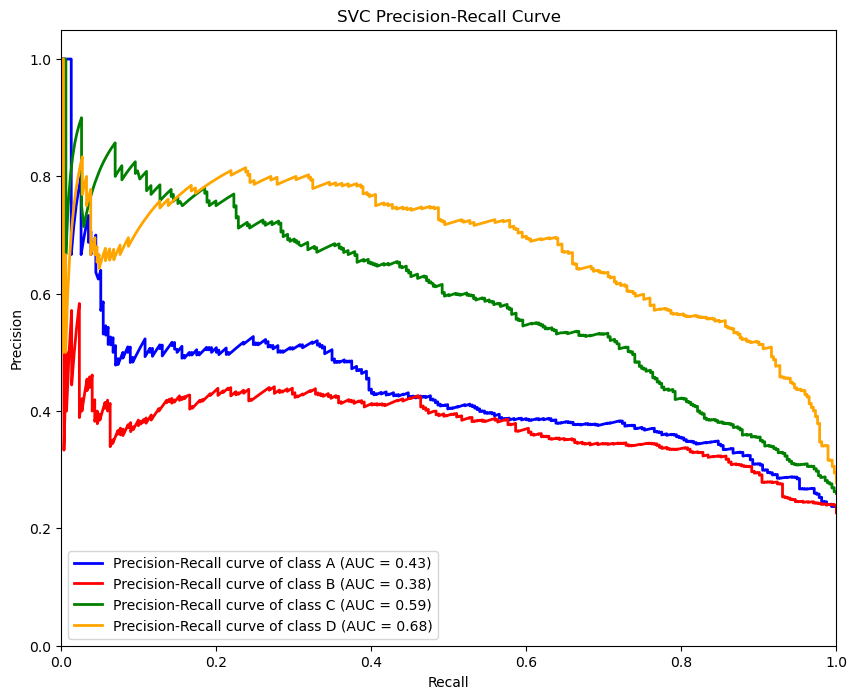

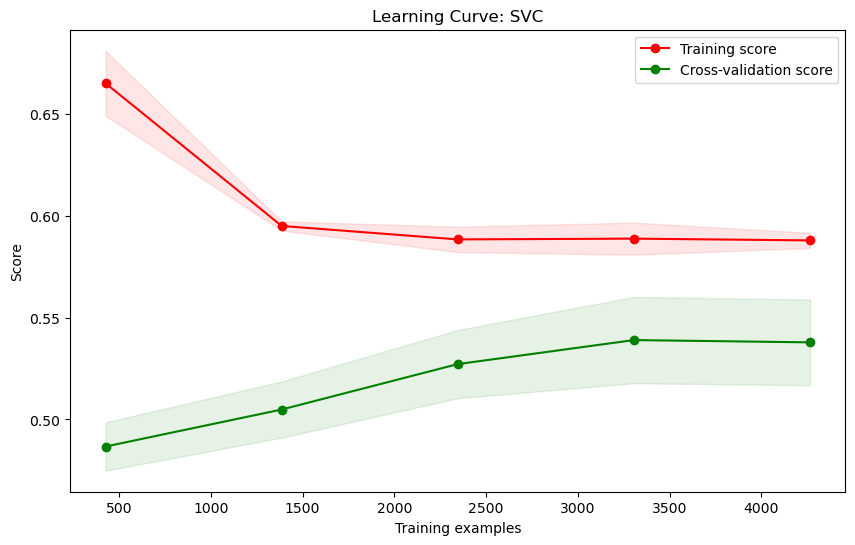

In [30]:
plot_confusion_matrix(svc_model_name, y_test, svc_y_test_predictions)
plot_roc_curve(svc_model_name, y_test, svc_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(svc_model_name, y_test, svc_y_test_prediction_probabilities)
plot_learning_curve(svc_best_model, X_train, y_train, svc_model_name)

In [31]:
naive_bayes_model_name = "Naive Bayes"

naive_bayes_best_model = results[naive_bayes_model_name]["best_model"]

naive_bayes_y_test_predictions = results[naive_bayes_model_name]["y_test_predictions"]
naive_bayes_y_test_prediction_probabilities = results[naive_bayes_model_name]["y_test_prediction_probabilities"]

naive_bayes_accuracy = results[naive_bayes_model_name]["accuracy"]
naive_bayes_precision = results[naive_bayes_model_name]["precision"]
naive_bayes_recall = results[naive_bayes_model_name]["recall"]
naive_bayes_f1_score = results[naive_bayes_model_name]["f1"]

In [32]:
naive_bayes_accuracy_string = f"{naive_bayes_model_name} Accuracy: {naive_bayes_accuracy}"
naive_bayes_precision_string = f"{naive_bayes_model_name} Precision: {naive_bayes_precision}"
naive_bayes_recall_string = f"{naive_bayes_model_name} Recall: {naive_bayes_recall}"
naive_bayes_f1_score_string = f"{naive_bayes_model_name} F1 Score: {naive_bayes_f1_score}"

naive_bayes_best_hyperparameters = results["Naive Bayes"]["best_params"]
print(f"{naive_bayes_model_name} Model Best Hyperparameter Combination: {naive_bayes_best_hyperparameters}")
print()
print(naive_bayes_accuracy_string)
print(naive_bayes_precision_string)
print(naive_bayes_recall_string)
print(naive_bayes_f1_score_string)

Naive Bayes Model Best Hyperparameter Combination: {}

Naive Bayes Accuracy: 0.45461365341335336
Naive Bayes Precision: 0.44838183471139315
Naive Bayes Recall: 0.45461365341335336
Naive Bayes F1 Score: 0.4249506285469809


<Figure size 1200x800 with 0 Axes>

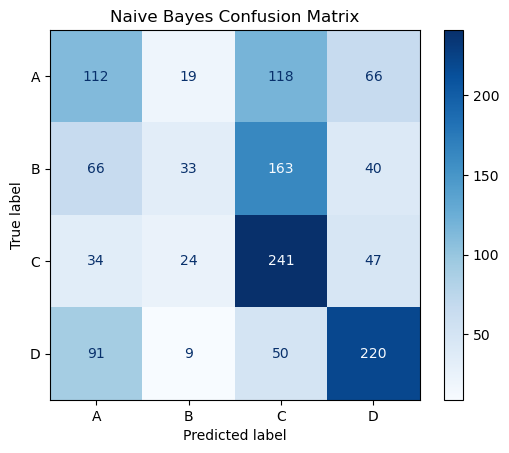

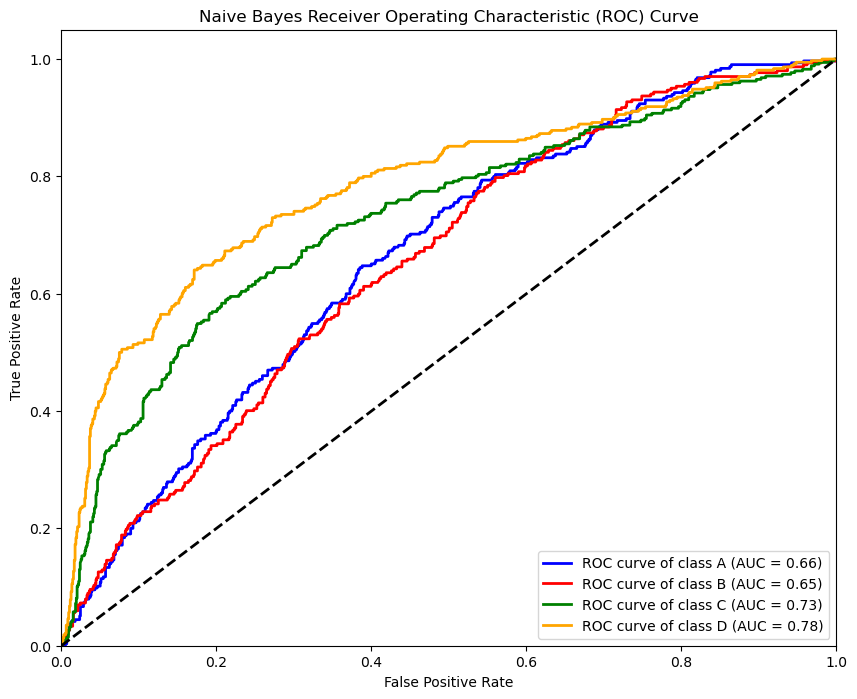

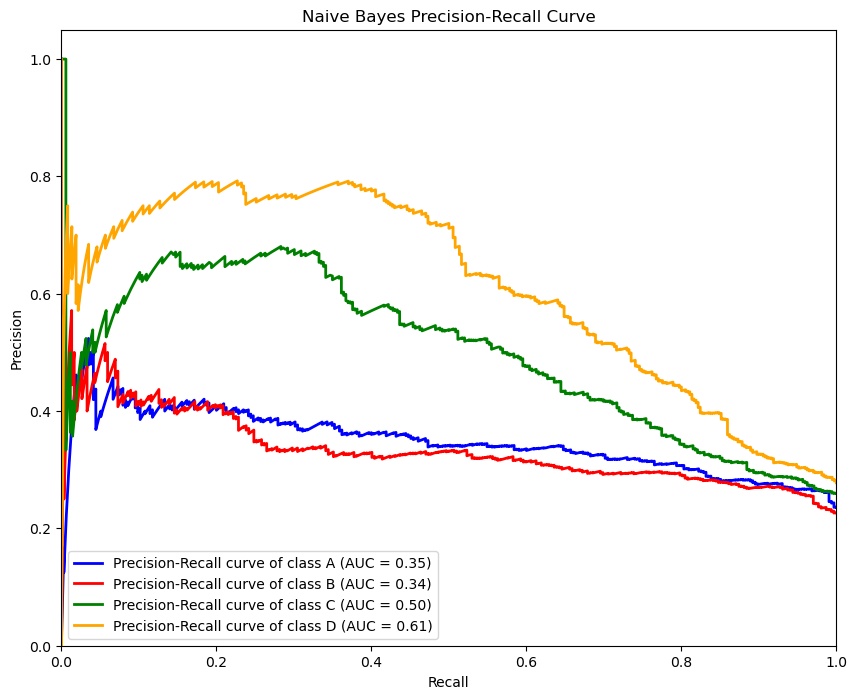

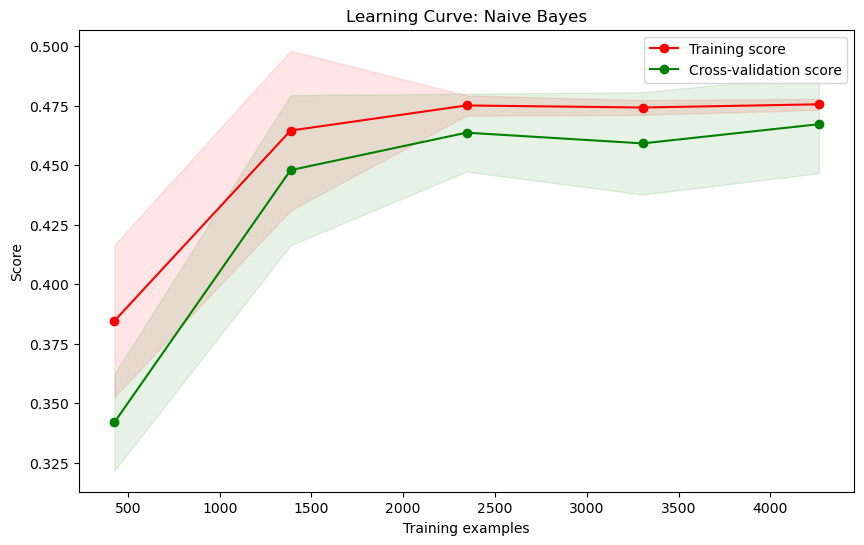

In [33]:
plot_confusion_matrix(naive_bayes_model_name, y_test, naive_bayes_y_test_predictions)
plot_roc_curve(naive_bayes_model_name, y_test, naive_bayes_y_test_prediction_probabilities)
plot_multiclass_precision_recall_curve(naive_bayes_model_name, y_test, naive_bayes_y_test_prediction_probabilities)
plot_learning_curve(naive_bayes_best_model, X_train, y_train, naive_bayes_model_name)